In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
!gdown --id '1e0T6Lc0PUwsCO4VAfmd4ADDk0FaCq8_m' --output level-6.csv

Downloading...
From: https://drive.google.com/uc?id=1e0T6Lc0PUwsCO4VAfmd4ADDk0FaCq8_m
To: /content/level-6.csv
100% 248k/248k [00:00<00:00, 2.47MB/s]


In [ ]:
train = pd.read_csv("level-6.csv")
train.head()

,index,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrocosmicus,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrososphaera,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;__,Archaea;Thermoplasmatota;Thermoplasmata;Thermoplasmatales;Thermoplasmataceae;uncultured,Archaea;__;__;__;__;__,Bacteria;Abditibacteriota;Abditibacteria;Abditibacteriales;Abditibacteriaceae;Abditibacterium,Bacteria;Acidobacteria;Acidobacteriia;Acidobacteriales;Acidobacteriaceae;PAC001990,Bacteria;Acidobacteria;Blastocatellia;Blastocatellales;PAC000004;EU192989,Bacteria;Acidobacteria;CP011806;CP011806;CP011806;CP011806,Bacteria;Acidobacteria;CP011806;CP011806;PAC002217;PAC002217,Bacteria;Acidobacteria;PAC001813;PAC001813;PAC001813;PAC001813,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;PAC001852,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;PAC002038,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;__,Bacteria;Acidobacteria;Solibacteres;Solibacterales;Bryobacteraceae;PAC002019,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;PAC002281;PAC002281,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;Vicinamibacter;PAC001869,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;Vicinamibacter;PAC001874,Bacteria;Acidobacteriota;Acidobacteriae;Acidobacteriales;Acidobacteriaceae_(Subgroup_1);uncultured,Bacteria;Acidobacteriota;Acidobacteriae;Bryobacterales;Bryobacteraceae;Bryobacter,Bacteria;Acidobacteriota;Blastocatellia;11-24;__;__,Bacteria;Acidobacteriota;Blastocatellia;11-24;uncultured_Pelobacter_sp.;,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Aridibacter,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;__,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;uncultured,Bacteria;Acidobacteriota;Blastocatellia;Elev-16S-573;uncultured_microorganism;,Bacteria;Acidobacteriota;Blastocatellia;Pyrinomonadales;Pyrinomonadaceae;RB41,Bacteria;Acidobacteriota;Holophagae;Subgroup_7;Acidobacteria_bacterium;,Bacteria;Acidobacteriota;Holophagae;Subgroup_7;__;__,Bacteria;Acidobacteriota;Subgroup_11;__;__;__,Bacteria;Acidobacteriota;Subgroup_11;uncultured_sponge_symbiont_PAUC37f;;__,Bacteria;Acidobacteriota;Subgroup_18;alkali_sediment_metagenome;;__,Bacteria;Acidobacteriota;Subgroup_22;__;__;__,Bacteria;Acidobacteriota;Subgroup_25;uncultured_Firmicutes_bacterium;;__,Bacteria;Acidobacteriota;Subgroup_5;uncultured_Acidobacteriales_bacterium;;__,Bacteria;Acidobacteriota;Thermoanaerobaculia;Thermoanaerobaculales;Thermoanaerobaculaceae;Subgroup_10,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;__;__,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;agricultural_soil_bacterium_SC-I-8;,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;uncultured_Holophaga_sp.;,...,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Psychrobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;Hydrocarboniphaga,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;Nevskia,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;Steroidobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Rhodanobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Arenimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Luteimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonada

In [ ]:
# shortrun = train[train['Merged'] < 920].index
# train = train.drop(shortrun,axis=0)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Columns: 590 entries, index to Cancer
dtypes: float64(587), int64(1), object(2)
memory usage: 567.1+ KB


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Columns: 590 entries, index to Cancer
dtypes: float64(587), int64(1), object(2)
memory usage: 567.1+ KB


In [ ]:
CAT_COL = ["index", "Cancer"]

NUM_COL=[]
for i in range(len(train.columns)):
  NUM_COL.append(train.columns[i])
NUM_COL.remove('index')
NUM_COL.remove('Cancer')

cat_col = []
num_col = []
for col in train:
  if col in CAT_COL:
    cat_col.append(col)
  elif col in NUM_COL:
    num_col.append(col)
for col in cat_col:
  train[col] = train[col].astype(str)

df_cat = train.loc[:,cat_col] # take all the categorical columns
df_cat = pd.get_dummies(df_cat) # one hot encoding

df_num = train.loc[:,num_col] # take all the numerical columns
df_final = pd.concat([df_cat, df_num], axis=1) # concat categorical/numerical data

In [ ]:
df_final.head()

,index_SRR8902009,index_SRR8902010,index_SRR8902011,index_SRR8902012,index_SRR8902013,index_SRR8902014,index_SRR8902015,index_SRR8902016,index_SRR8902017,index_SRR8902018,index_SRR8902019,index_SRR8902020,index_SRR8902021,index_SRR8902022,index_SRR8902023,index_SRR8902024,index_SRR8902025,index_SRR8902026,index_SRR8902027,index_SRR8902028,index_SRR8902029,index_SRR8902030,index_SRR8902031,index_SRR8902032,index_SRR8902033,index_SRR8902034,index_SRR8902035,index_SRR8902036,index_SRR8902037,index_SRR8902038,index_SRR8902039,index_SRR8902040,index_SRR8902041,index_SRR8902042,index_SRR8902043,index_SRR8902044,index_SRR8902045,index_SRR8902046,index_SRR8902047,index_SRR8902048,...,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Enhydrobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Psychrobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;Hydrocarboniphaga,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;Nevskia,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;Steroidobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Rhodanobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Arenimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Luteimonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Lysobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Pseudoxanthomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Stenotrophomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Thermomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Vulcaniibacterium,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;__;__;__,Bacteria;Proteobacteria;__;__;__;__,Bacteria;SAR324_clade(Marine_group_B);uncultured_Phaselicystis_sp.;;__;__,Bacteria;Spirochaetota;Spirochaetia;Spirochaetales;Spirochaetaceae;Sediminispirochaeta,Bacteria;Spirochaetota;Spirochaetia;Spirochaetales;Spirochaetaceae;Treponema,Bacteria;Sva0485;uncultured_Geobacter_sp.;;__;__,Bacteria;Synergistota;Synergistia;Synergistales;Synergistaceae;Fretibacterium,Bacteria;Synergistota;Synergistia;Synergistales;Synergistaceae;Pyramidobacter,Bacteria;Tenericutes;Mollicutes;Bacilloplasma;Lumbricoplasmataceae;GQ866067,Bacteria;Verrucomicrobiota;Lentisphaeria;Victivallales;Victivallaceae;Victivallis,Bacteria;Verrucomicrobiota;Omnitrophia;Omnitrophales;Omnitrophaceae;Candidatus_Omnitrophus,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Chthoniobacterales;Chthoniobacteraceae;Candidatus_Udaeobacter,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Chthoniobacterales;Chthoniobacteraceae;LD29,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Opitutales;Opitutaceae;IMCC26134,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Pedosphaerales;Pedosphaeraceae;ADurb.Bin063-1,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Verrucomicrobiales;Akkermansiaceae;Akkermansia,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Verrucomicrobiales;Verrucomicrobiaceae;Prosthecobacter,Bacteria;Zixibacteria;uncultured_gamma_proteobacterium;;__;__,Bacteria;__;__;__;__;__,Unassigned;__;__;__;__;__,Merged
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000093,0.0,0.0,0.009615,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001393,0.

In [ ]:
not_select = ["index", "Cancer", "Merged"]
train_select = train.drop(not_select,axis=1)
train_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Columns: 587 entries, Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrocosmicus to Unassigned;__;__;__;__;__
dtypes: float64(587)
memory usage: 564.2 KB


In [ ]:
cat_col = []
num_col = []
for col in train_select:
  if col in CAT_COL:
    cat_col.append(col)
  elif col in NUM_COL:
    num_col.append(col)

for col in cat_col:
  if train_select[col].dtype != "O":
    # print(col)
    train_select[col] = train_select[col].astype(str)

df_cat_select = train_select.loc[:,cat_col] # take all the categorical columns
#df_cat_select = pd.get_dummies(df_cat_select) # one hot encoding

df_num_select = train_select.loc[:,num_col] # take all the numerical columns
df_final_select = pd.concat([df_cat_select, df_num_select], axis=1) # concat categorical/numerical data

In [ ]:
df_final_select.head()

,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrocosmicus,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;Candidatus_Nitrososphaera,Archaea;Crenarchaeota;Nitrososphaeria;Nitrososphaerales;Nitrososphaeraceae;__,Archaea;Thermoplasmatota;Thermoplasmata;Thermoplasmatales;Thermoplasmataceae;uncultured,Archaea;__;__;__;__;__,Bacteria;Abditibacteriota;Abditibacteria;Abditibacteriales;Abditibacteriaceae;Abditibacterium,Bacteria;Acidobacteria;Acidobacteriia;Acidobacteriales;Acidobacteriaceae;PAC001990,Bacteria;Acidobacteria;Blastocatellia;Blastocatellales;PAC000004;EU192989,Bacteria;Acidobacteria;CP011806;CP011806;CP011806;CP011806,Bacteria;Acidobacteria;CP011806;CP011806;PAC002217;PAC002217,Bacteria;Acidobacteria;PAC001813;PAC001813;PAC001813;PAC001813,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;PAC001852,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;PAC002038,Bacteria;Acidobacteria;PAC001852;PAC001852;PAC001852;__,Bacteria;Acidobacteria;Solibacteres;Solibacterales;Bryobacteraceae;PAC002019,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;PAC002281;PAC002281,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;Vicinamibacter;PAC001869,Bacteria;Acidobacteria;Vicinamibacter;Vicinamibacter;Vicinamibacter;PAC001874,Bacteria;Acidobacteriota;Acidobacteriae;Acidobacteriales;Acidobacteriaceae_(Subgroup_1);uncultured,Bacteria;Acidobacteriota;Acidobacteriae;Bryobacterales;Bryobacteraceae;Bryobacter,Bacteria;Acidobacteriota;Blastocatellia;11-24;__;__,Bacteria;Acidobacteriota;Blastocatellia;11-24;uncultured_Pelobacter_sp.;,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Aridibacter,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;__,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;uncultured,Bacteria;Acidobacteriota;Blastocatellia;Elev-16S-573;uncultured_microorganism;,Bacteria;Acidobacteriota;Blastocatellia;Pyrinomonadales;Pyrinomonadaceae;RB41,Bacteria;Acidobacteriota;Holophagae;Subgroup_7;Acidobacteria_bacterium;,Bacteria;Acidobacteriota;Holophagae;Subgroup_7;__;__,Bacteria;Acidobacteriota;Subgroup_11;__;__;__,Bacteria;Acidobacteriota;Subgroup_11;uncultured_sponge_symbiont_PAUC37f;;__,Bacteria;Acidobacteriota;Subgroup_18;alkali_sediment_metagenome;;__,Bacteria;Acidobacteriota;Subgroup_22;__;__;__,Bacteria;Acidobacteriota;Subgroup_25;uncultured_Firmicutes_bacterium;;__,Bacteria;Acidobacteriota;Subgroup_5;uncultured_Acidobacteriales_bacterium;;__,Bacteria;Acidobacteriota;Thermoanaerobaculia;Thermoanaerobaculales;Thermoanaerobaculaceae;Subgroup_10,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;__;__,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;agricultural_soil_bacterium_SC-I-8;,Bacteria;Acidobacteriota;Vicinamibacteria;Subgroup_17;uncultured_Holophaga_sp.;,Bacteria;Acidobacteriota;Vicinamibacteria;Vicinamibacterales;Vicinamibacteraceae;Luteitalea,...,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Acinetobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Enhydrobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Psychrobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;Hydrocarboniphaga,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;Nevskia,Bacteria;Proteobacteria;Gammaproteobacteria;Salinisphaerales;Solimonadaceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;Steroidobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Steroidobacterales;Steroidobacteraceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;

#DNN

In [ ]:
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']= '2'

In [ ]:
target_var = 'Cancer'
features = list(df_final_select.columns)
# 目標變量的類別
Class = train[target_var].unique()
# 目標變量的類別字典
Class_dict = dict(zip(Class, range(len(Class))))
# 增加一列target, 將目標變量進行編碼
train['target'] = train[target_var].apply(lambda x: Class_dict[x])
# 對目標變量進行0-1編碼(One-hot Encoding)
lb = LabelBinarizer()
lb.fit(list(Class_dict.values()))
transformed_labels = lb.transform(train['target'])
label2 = np.zeros((123,1))

for i in range(len(transformed_labels)):
  if transformed_labels[i][0] == 0:
    label2[i][0] = np.int(1)
  elif transformed_labels[i][0] == 1:
    label2[i][0] = np.int(0)

transformed_labels = np.concatenate((transformed_labels, label2),axis=1)

y_bin_labels = []  # 對多分類進行0-1編碼的變量
for i in range(transformed_labels.shape[1]):
    y_bin_labels.append( 'y' + str(i))
    train['y' + str(i)] = transformed_labels[:, i]
# 將數據集分為訓練集和測試集
train_x, test_x, train_y, test_y = train_test_split(df_final_select[features], train[y_bin_labels], train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
np.random.seed(5)
# model
init = K.initializers.glorot_uniform(seed=1)
model = K.models.Sequential()
model.add(K.layers.Dense(units=30, input_dim=587, kernel_initializer=init, activation='relu'))
model.add(K.layers.Dense(units=5, input_dim=30, kernel_initializer=init, activation='relu'))
model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='relu'))

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 30)                17640     
_________________________________________________________________
dense_41 (Dense)             (None, 5)                 155       
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 12        
Total params: 17,807
Trainable params: 17,807
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 訓練模型
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy',
        metrics=['accuracy'])

h = model.fit(train_x, train_y, epochs=50, batch_size=4,
      validation_data=(test_x, test_y))

Epoch 1/50
25/25 [==============================] - 1s 13ms/step - loss: nan - accuracy: 0.4898 - val_loss: 4.2741 - val_accuracy: 0.5200
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 2.7151 - accuracy: 0.5204 - val_loss: 2.0539 - val_accuracy: 0.4800
Epoch 3/50
25/25 [==============================] - 0s 3ms/step - loss: 1.4692 - accuracy: 0.5612 - val_loss: 0.8032 - val_accuracy: 0.7200
Epoch 4/50
25/25 [==============================] - 0s 3ms/step - loss: 1.3165 - accuracy: 0.6020 - val_loss: 0.6368 - val_accuracy: 0.6000
Epoch 5/50
25/25 [==============================] - 0s 3ms/step - loss: 1.2605 - accuracy: 0.5816 - val_loss: 0.6042 - val_accuracy: 0.6800
Epoch 6/50
25/25 [==============================] - 0s 3ms/step - loss: 1.2172 - accuracy: 0.6531 - val_loss: 0.5341 - val_accuracy: 0.7600
Epoch 7/50
25/25 [==============================] - 0s 3ms/step - loss: 1.1996 - accuracy: 0.6327 - val_loss: 0.4993 - val_accuracy: 0.8000
Epoch 8/50
25/25 [====

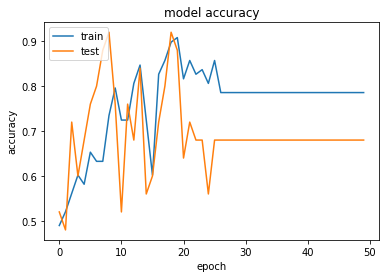

In [ ]:
# summarize history for accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#PH-CNN
##reference:
###https://github.com/dfioravanti/phylogenetic-cnn
###https://www.tensorflow.org/tutorials/images/cnn

In [ ]:
import os
from tensorflow.keras import datasets, layers, models

##Import coordinate data

In [ ]:
#reshape
!gdown --id '1HgYWrJfHoQ4wnQFbvN7FTk4_hmsIBsQ4' --output ordinate.csv
C = pd.read_csv("ordinate.csv")
# Xs = df_final_select.values

Downloading...
From: https://drive.google.com/uc?id=1HgYWrJfHoQ4wnQFbvN7FTk4_hmsIBsQ4
To: /content/ordinate.csv
100% 83.6k/83.6k [00:00<00:00, 1.31MB/s]


In [ ]:
# C = C.drop(shortrun,axis=0)
C.head()

,index,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,Merged,Cancer
0,SRR8902009,-1.911565,-0.130933,0.241523,-0.186078,0.077002,-0.089216,0.099553,-0.005171,0.070688,-0.079547,0.039522,0.004842,0.053914,-0.017129,0.009014,-0.025193,0.027081,-0.022814,-0.011557,0.005086,0.005741,-0.000445,-0.018710,-0.030781,-0.013815,0.012013,-0.010422,0.006829,-0.014077,-0.002617,0.010747,0.007030,-0.003023,0.006745,0.003035,0.001295,0.003207,-0.001052,-0.000695,1.670000e-07,0.001888,-0.000115,-0.000152,-0.000195,-0.000474,0.000589,0.000192,0.000608,0.000352,-0.000154,0.000109,-0.000076,0.000022,43058,non-cancer
1,SRR8902010,-0.670388,-0.139795,-0.143867,0.034392,-0.083314,0.019363,-0.095083,-0.012729,-0.011440,-0.048129,-0.014132,-0.029556,0.022631,0.014344,0.012266,0.007994,0.012941,0.032526,-0.011803,0.003206,0.000344,-0.017838,0.005328,0.025024,-0.025832,0.002351,0.006479,-0.004508,-0.013529,0.011298,0.019441,0.009865,-0.008397,-0.006525,0.005525,-0.001332,-0.001145,-0.000582,0.001307,8.495410e-04,0.001288,-0.000104,0.000844,0.002350,0.001816,0.000212,-0.000466,0.000353,0.000300,-0.000340,0.000392,0.000079,-0.000013,53224,non-cancer
2,SRR8902011,-0.464162,0.164427,0.015042,0.102230,-0.117228,-0.076915,0.120495,-0.084897,-0.032670,-0.008778,-0.044142,0.036700,-0.000531,-0.044393,-0.020713,0.014254,-0.005428,-0.036960,-0.009586,0.048998,-0.006120,-0.003565,0.032228,-0.047669,-0.006488,-0.000774,0.011437,-0.023980,-0.022038,0.013284,-0.006805,0.002464,0.008513,0.005854,-0.003138,0.001961,-0.006615,-0.000565,0.001220,4.356303e-03,0.000495,0.001300,-0.000936,-0.000295,-0.001083,0.000206,-0.001323,0.000214,-0.000069,0.000222,-0.000252,-0.000182,0.000072,38463,non-cancer
3,SRR8902012,-0.145446,0.239443,-0.114709,0.339471,0.053531,0.130749,0.167982,0.104918,-0.011611,0.042453,0.053314,-0.060781,-0.003986,-0.000609,0.027233,-0.010224,0.015341,-0.003070,-0.008556,-0.003393,0.002096,0.000035,0.006360,-0.003833,0.013008,0.008176,0.000320,0.000910,-0.001126,-0.004030,-0.005569,0.001904,-0.003949,-0.002314,0.000568,-0.000578,0.001194,0.000007,-0.001075,3.478540e-04,0.000528,-0.000159,0.000291,-0.001547,0.000334,-0.000057,0.000072,0.000032,-0.000092,-0.000048,-0.000007,0.000060,-0.000061,32140,non-cancer
4,SRR8902013,0.284827,-0.045105,-0.005029,0.013437,0.042888,-0.001357,-0.025879,0.007970,-0.026813,-0.028465,-0.001895,0.024499,-0.010677,-0.007326,0.022309,0.009375,0.004422,0.003244,0.002572,0.003097,-0.004964,0.014000,0.008550,0.003091,-0.003124,0.001013,0.007608,-0.000193,0.004409,0.001048,-0.004593,0.005518,0.007060,0.003847,0.002859,-0.005296,0.003714,-0.007572,0.003925,1.597404e-03,0.008585,-0.001469,0.001439,0.001883,-0.005489,-0.003538,0.000106,-0.000395,-0.000833,-0.001615,0.003547,-0.003226,-0.001859,56985,non-cancer


In [ ]:
not_select=['index', 'Merged','Cancer']
C_final = C.drop(not_select,axis=1)
C_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 53 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       123 non-null    float64
 1   2       123 non-null    float64
 2   3       123 non-null    float64
 3   4       123 non-null    float64
 4   5       123 non-null    float64
 5   6       123 non-null    float64
 6   7       123 non-null    float64
 7   8       123 non-null    float64
 8   9       123 non-null    float64
 9   10      123 non-null    float64
 10  11      123 non-null    float64
 11  12      123 non-null    float64
 12  13      123 non-null    float64
 13  14      123 non-null    float64
 14  15      123 non-null    float64
 15  16      123 non-null    float64
 16  17      123 non-null    float64
 17  18      123 non-null    float64
 18  19      123 non-null    float64
 19  20      123 non-null    float64
 20  21      123 non-null    float64
 21  22      123 non-null    float64
 22  23

In [ ]:
C_final.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
0,-1.911565,-0.130933,0.241523,-0.186078,0.077002,-0.089216,0.099553,-0.005171,0.070688,-0.079547,0.039522,0.004842,0.053914,-0.017129,0.009014,-0.025193,0.027081,-0.022814,-0.011557,0.005086,0.005741,-0.000445,-0.018710,-0.030781,-0.013815,0.012013,-0.010422,0.006829,-0.014077,-0.002617,0.010747,0.007030,-0.003023,0.006745,0.003035,0.001295,0.003207,-0.001052,-0.000695,1.670000e-07,0.001888,-0.000115,-0.000152,-0.000195,-0.000474,0.000589,0.000192,0.000608,0.000352,-0.000154,0.000109,-0.000076,0.000022
1,-0.670388,-0.139795,-0.143867,0.034392,-0.083314,0.019363,-0.095083,-0.012729,-0.011440,-0.048129,-0.014132,-0.029556,0.022631,0.014344,0.012266,0.007994,0.012941,0.032526,-0.011803,0.003206,0.000344,-0.017838,0.005328,0.025024,-0.025832,0.002351,0.006479,-0.004508,-0.013529,0.011298,0.019441,0.009865,-0.008397,-0.006525,0.005525,-0.001332,-0.001145,-0.000582,0.001307,8.495410e-04,0.001288,-0.000104,0.000844,0.002350,0.001816,0.000212,-0.000466,0.000353,0.000300,-0.000340,0.000392,0.000079,-0.000013
2,-0.464162,0.164427,0.015042,0.102230,-0.117228,-0.076915,0.120495,-0.084897,-0.032670,-0.008778,-0.044142,0.036700,-0.000531,-0.044393,-0.020713,0.014254,-0.005428,-0.036960,-0.009586,0.048998,-0.006120,-0.003565,0.032228,-0.047669,-0.006488,-0.000774,0.011437,-0.023980,-0.022038,0.013284,-0.006805,0.002464,0.008513,0.005854,-0.003138,0.001961,-0.006615,-0.000565,0.001220,4.356303e-03,0.000495,0.001300,-0.000936,-0.000295,-0.001083,0.000206,-0.001323,0.000214,-0.000069,0.000222,-0.000252,-0.000182,0.000072
3,-0.145446,0.239443,-0.114709,0.339471,0.053531,0.130749,0.167982,0.104918,-0.011611,0.042453,0.053314,-0.060781,-0.003986,-0.000609,0.027233,-0.010224,0.015341,-0.003070,-0.008556,-0.003393,0.002096,0.000035,0.006360,-0.003833,0.013008,0.008176,0.000320,0.000910,-0.001126,-0.004030,-0.005569,0.001904,-0.003949,-0.002314,0.000568,-0.000578,0.001194,0.000007,-0.001075,3.478540e-04,0.000528,-0.000159,0.000291,-0.001547,0.000334,-0.000057,0.000072,0.000032,-0.000092,-0.000048,-0.000007,0.000060,-0.000061
4,0.284827,-0.045105,-0.005029,0.013437,0.042888,-0.001357,-0.025879,0.007970,-0.026813,-0.028465,-0.001895,0.024499,-0.010677,-0.007326,0.022309,0.009375,0.004422,0.003244,0.002572,0.003097,-0.004964,0.014000,0.008550,0.003091,-0.003124,0.001013,0.007608,-0.000193,0.004409,0.001048,-0.004593,0.005518,0.007060,0.003847,0.002859,-0.005296,0.003714,-0.007572,0.003925,1.597404e-03,0.008585,-0.001469,0.001439,0.001883,-0.005489,-0.003538,0.000106,-0.000395,-0.000833,-0.001615,0.003547,-0.003226,-0.001859


In [ ]:
X_final = pd.concat([df_final_select, C_final], axis=1)
X_final.shape

(123, 640)

In [ ]:
target_var = 'Cancer'
features = list(X_final.columns)
# 目標變量的類別
Class = train[target_var].unique()
# 目標變量的類別字典
Class_dict = dict(zip(Class, range(len(Class))))
# 增加一列target, 將目標變量進行編碼
train['target'] = train[target_var].apply(lambda x: Class_dict[x])
# 對目標變量進行0-1編碼(One-hot Encoding)
lb = LabelBinarizer()
lb.fit(list(Class_dict.values()))
transformed_labels = lb.transform(train['target'])
label2 = np.zeros((123,1))

for i in range(len(transformed_labels)):
  if transformed_labels[i][0] == 0:
    label2[i][0] = np.int(1)
  elif transformed_labels[i][0] == 1:
    label2[i][0] = np.int(0)

transformed_labels = np.concatenate((transformed_labels, label2),axis=1)

y_bin_labels = []  # 對多分類進行0-1編碼的變量
for i in range(transformed_labels.shape[1]):
    y_bin_labels.append( 'y' + str(i))
    train['y' + str(i)] = transformed_labels[:, i]
# 將數據集分為訓練集和測試集
train_x, test_x, train_y, test_y = train_test_split(X_final[features], train[y_bin_labels], train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
print(train_x.shape)
print(test_x.shape)

(98, 640)
(25, 640)


In [ ]:
train_x = train_x.values.reshape(98, 4, 4, 40)
train_x = train_x.reshape(98, 4, 4, 40)
test_x = test_x.values.reshape(25, 4, 4, 40)
test_x = test_x.reshape(25, 4, 4, 40)

## Model(Same as paper)

In [ ]:
model = K.models.Sequential()
model.add(K.layers.Conv2D(40, (3, 3), activation='relu', input_shape=train_x.shape[1:]))
model.add(K.layers.Conv2D(20, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
model.add(K.layers.MaxPooling2D((2, 2)))
model.add(K.layers.Flatten())
model.add(K.layers.Dense(64, activation= 'relu'))
model.add(K.layers.Dropout(0.25))
model.add(K.layers.Dense(2,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2, 2, 40)          14440     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 20)          820       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1344      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
# opt = K.optimizers.Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy',
        metrics=['accuracy'])

h2 = model.fit(train_x, train_y, epochs=50, batch_size=4,
      validation_data=(test_x, test_y))

Epoch 1/50
25/25 [==============================] - 31s 15ms/step - loss: 0.6949 - accuracy: 0.4796 - val_loss: 0.6880 - val_accuracy: 0.6000
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5204 - val_loss: 0.6883 - val_accuracy: 0.6800
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.6531 - val_loss: 0.6905 - val_accuracy: 0.5600
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5918 - val_loss: 0.6856 - val_accuracy: 0.8400
Epoch 5/50
25/25 [==============================] - 0s 5ms/step - loss: 0.6844 - accuracy: 0.6735 - val_loss: 0.6871 - val_accuracy: 0.6000
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6803 - accuracy: 0.7143 - val_loss: 0.6787 - val_accuracy: 0.7600
Epoch 7/50
25/25 [==============================] - 0s 5ms/step - loss: 0.6758 - accuracy: 0.7653 - val_loss: 0.6822 - val_accuracy: 0.5600
Epoch 8/50
25/25 [

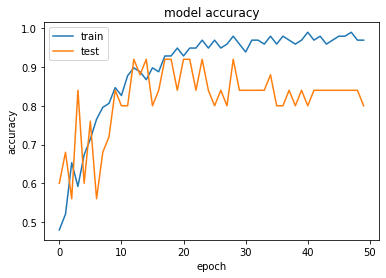

In [ ]:
# summarize history for accuracy
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Model 2
Activation = relu  
No Dropout

In [ ]:
model = K.models.Sequential()
model.add(K.layers.Conv2D(95, (3, 3), activation='relu', input_shape=train_x.shape[1:]))
# model.add(K.layers.Conv2D(50, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
# model.add(K.layers.MaxPooling2D((2, 2)))
model.add(K.layers.Flatten())
model.add(K.layers.Dense(32, activation= 'relu'))
model.add(K.layers.Dropout(0.15))
model.add(K.layers.Dense(2,activation='relu'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 2, 2, 95)          34295     
_________________________________________________________________
flatten_1 (Flatten)          (None, 380)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                12192     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 46,553
Trainable params: 46,553
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0003, decay=1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy',
        metrics=['accuracy'])

h2 = model.fit(train_x, train_y, epochs=50, batch_size=4,
      validation_data=(test_x, test_y))

Epoch 1/50
25/25 [==============================] - 1s 12ms/step - loss: nan - accuracy: 0.4694 - val_loss: 0.6882 - val_accuracy: 0.5600
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.5612 - val_loss: 0.6202 - val_accuracy: 0.6800
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6768 - accuracy: 0.6327 - val_loss: 0.6268 - val_accuracy: 0.6400
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6489 - accuracy: 0.5918 - val_loss: 0.6378 - val_accuracy: 0.8400
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6378 - accuracy: 0.6327 - val_loss: 0.6460 - val_accuracy: 0.8800
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6279 - accuracy: 0.6531 - val_loss: 0.7318 - val_accuracy: 0.8800
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5750 - accuracy: 0.6531 - val_loss: 1.2137 - val_accuracy: 0.8800
Epoch 8/50
25/25 [=======

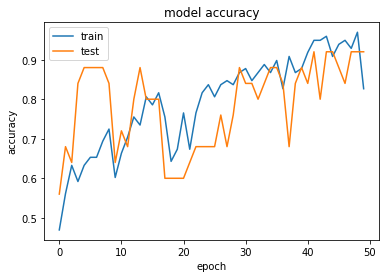

In [ ]:
# summarize history for accuracy
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()